In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi ['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [6]:
Xtr , Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #back

    for p  in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


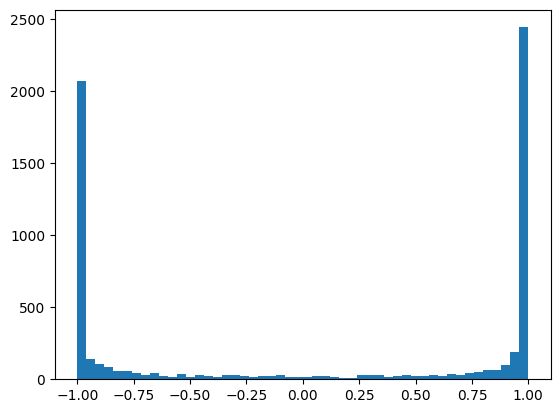

In [9]:
h # alot of values are at the limit of tanh

h.shape
plt.hist(h.view(-1).tolist(),50); # most values by far take on values at the extremes

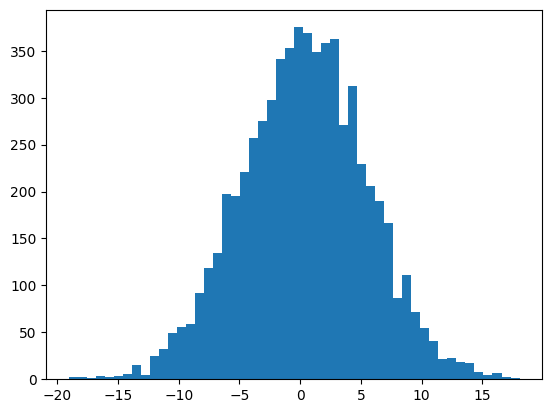

In [10]:
# We can look at why that is by lookig at the preactivations
plt.hist(hpreact.view(-1).tolist(),50); # most values by far take on values at the extremes
# very broad values between -20 and 20
# This is bad because of backpropagation step for tanh
# in backward pass we take out.grad and multiply it with the local gradient: -(1 - t**2) * out.grad
# if you plug out t==1 you're gonna get a zero multiplied by out.grad and killing the gradient
# When we input at exactly 0, out.grad is passed through
# I.e. when t=0 the tanh unit is inactive and gradient just passed thtough while the more you are in the flat tails
# the more the gradient is squashed

# The gradient through tanh can only ever decrease (1- t**2) and the ammount is proportional to where 
# you are in the flat tail of the tahn


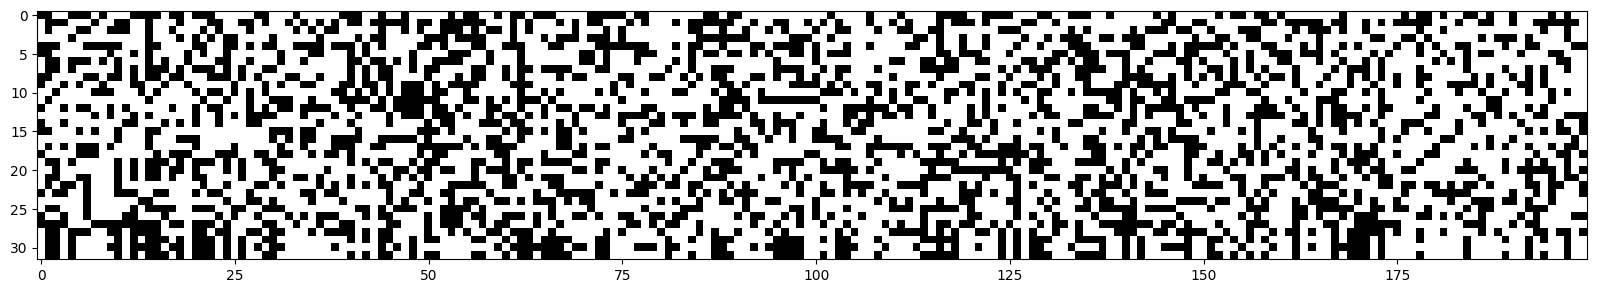

In [11]:
# We can get a sense of the problem as follows

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray",interpolation="nearest") # all white are in the flat tail and very active
                                                                # and the back gradient is destroyed
                                                                # if they were all white we have a dead neuron

# because there is no column of white we will be fine, however this is not optimal
# Again what happens is that the hpreact is too extreme and creating a distribution that is too saturated
# in both sides of the tanh meaning that there is less training for these neurons because they update less
# frequently

For a dead relu neuron
if a neuron with a relu non linearity never activates( always in the flat region) then this  relu neuron is a dead neuron and its weights and bias will never learn, will never activate and never get a gradient

This can happen at initialization by chance, with W and B making the neurons dead

Can also happen during optimization. when you have to high of a e.g: learning rate some of these neurons get to much of this gradient and get knocked out of the data manifold and from then on no example activates this neuron
so this neuron remains dead forever.
# Permanent brain damage 


In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 3.1878931522369385
val 3.187795877456665
test 3.1874477863311768


In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def predict():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

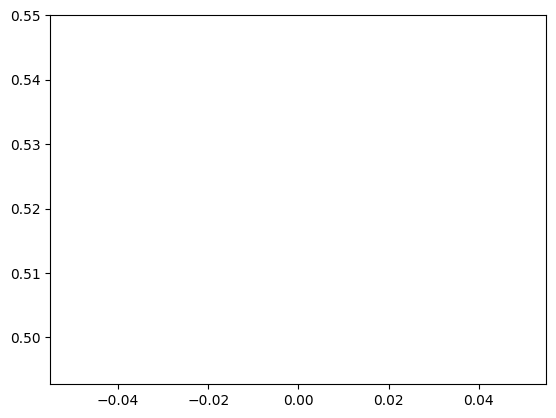

In [14]:
# problem
# Initialization
# at the 0-th iteration we are recording a loss of 25 which rapidly comes down to ~2
plt.plot(lossi)

In [15]:
# We want to assume at init that all 27 characters are equally likely
# probability for evey character should be 1./27.
# and then the loss is the negative log probability

-torch.tensor(1/27.0).log() # <-- the value that we should expect at initialization

tensor(3.2958)

In [16]:
# 4-dim example of the issue
#logits = torch.tensor([0.0,5.0,0.0,0.0])
logits =  torch.randn(4) * 10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs, loss
# we could luck out and assign the right probability at initialization giving us a low loss
# More likely is that another value will have very high logit returing a very high  loss 


# We want the logits to be roughly equal
# but by simetry we want it to be all zeros and record the loss we expect at initialization

(tensor([0.5709, 0.0027, 0.4229, 0.0035]), tensor(0.8606))

In [17]:
# Fixing the dead neurons

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #back

    for p  in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


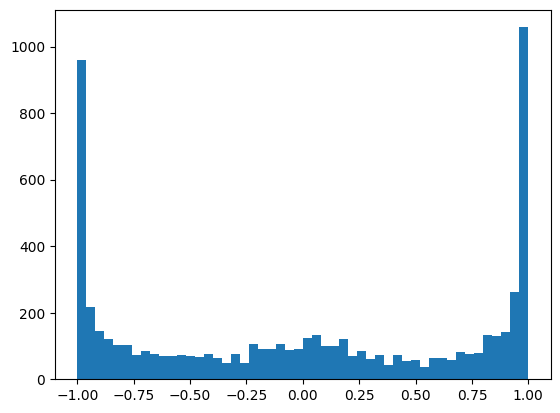

In [19]:
h # alot of values are at the limit of tanh

h.shape
plt.hist(h.view(-1).tolist(),50); # most values by far take on values at the extremes

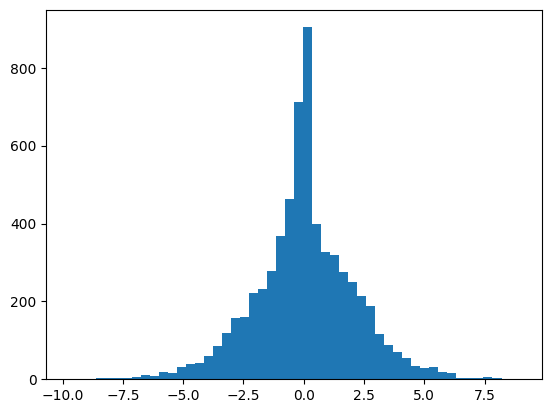

In [20]:
# We can look at why that is by lookig at the preactivations
plt.hist(hpreact.view(-1).tolist(),50); # most values by far take on values at the extremes
# very broad values between -20 and 20
# This is bad because of backpropagation step for tanh
# in backward pass we take out.grad and multiply it with the local gradient: -(1 - t**2) * out.grad
# if you plug out t==1 you're gonna get a zero multiplied by out.grad and killing the gradient
# When we input at exactly 0, out.grad is passed through
# I.e. when t=0 the tanh unit is inactive and gradient just passed thtough while the more you are in the flat tails
# the more the gradient is squashed

# The gradient through tanh can only ever decrease (1- t**2) and the ammount is proportional to where 
# you are in the flat tail of the tahn

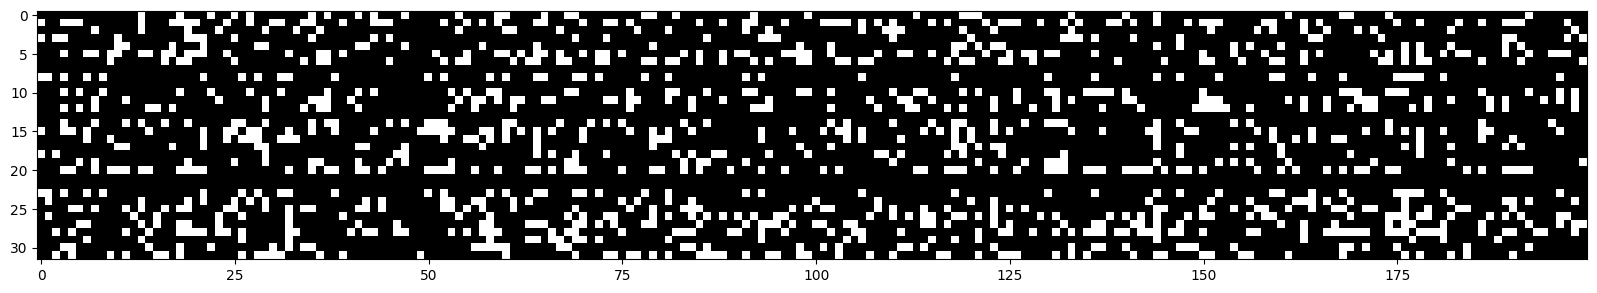

In [21]:
# We can get a sense of the problem as follows

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray",interpolation="nearest") # all white are in the flat tail and very active
                                                                # and the back gradient is destroyed
                                                                # if they were all white we have a dead neuron

# because there is no column of white we will be fine, however this is not optimal
# Again what happens is that the hpreact is too extreme and creating a distribution that is too saturated
# in both sides of the tanh meaning that there is less training for these neurons because they update less
# frequently

tensor(-0.0054) tensor(0.9873)
tensor(0.0041) tensor(0.9916)


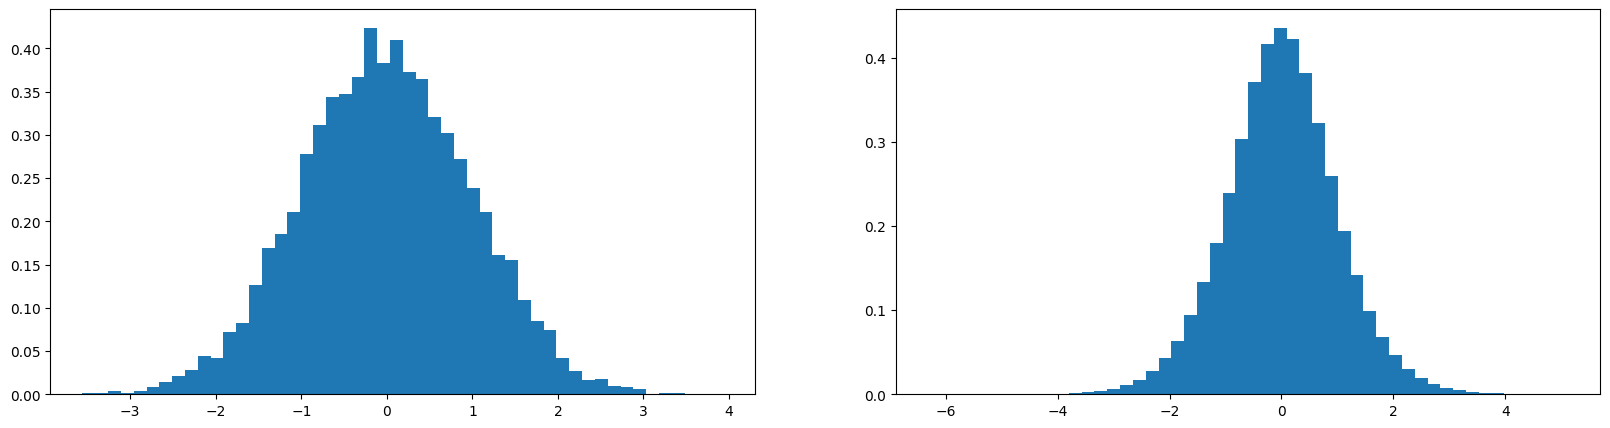

In [25]:
#How are we supposed to set the initialization with a lot of neurons and lots of layers
# input, weight initialized using gaussian
inp =  torch.randn(1000,10) # 1000 examples that are 10 dimensional
weight = torch.randn(10,200) / 10**0.5
out = inp @ weight
print(inp.mean(),inp.std()) # in the begining the mean and std is normal gaussian with mean = 0 and std = 1
print(out.mean(),out.std()) # once we multiply we see that the mean stays the same but the std changes
                            # so the gaussian changes and we do not want that
                            
                            # We want most of the neural net to have similar activations or unit gaussian 
                            # throughout the neural net
                            # The question becomes what do we use to multiply such that we preserve the standard
                            # deviation to be 1
                            # The answer is division by the squareroot of the fan_in
                            # i.e sqrt(input to the weights)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(inp.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(out.view(-1).tolist(),50,density=True);

We want to make sure that the activations are well behaved and they do not expand to infinity or shrink to 0
So the question becomes how do we initialize the weights so these activations take reasonable values

# TO READ: Kaiminig Init Paper: https://arxiv.org/pdf/1502.01852 (Hard read)
    In the paper they investigate RELU which sets to 0 all negative numbers effectively throwing away half of
    the distribution you have to compensate for that with a gain
    
    Init weights with a 0 mean Gaussian, with std srt(2/fan_in) ----> They have to add in this factor of 2  because of the relu which basically discards half of the distribution 

    The paper also studies the backpropagation and we have to make sure that the gradients are also well behaved because they are the ones that ultimately update our parameters.

    What they find is that if you properly init the forward pass, the backward pass is also approximately properly initialized up to a constant factor that has to do with the size of the number of hidden neurons in an early and a late layer. They find that this is not a choice that matters to much


# Kaiming init in Pytorch: https://pytorch.org/docs/stable/nn.init.html 

mode - do you want to normalize the activations or the gradients to be gaussian with 0 mean and 1 std
nonlinearity . the gain that we are using

Due to modern inovations we don't have to pay that much attention to this step
Some of those inovations are:
    Residual connections
    Normalization Layers - Batch Normalization, Layer Normalization, Group Normalization
    Much better optimizers . RMSProp and Adam

In [ ]:
(torch.randn(10000) * (5/3)).std()

tensor(0.1990)

In [ ]:
(5/3) / (30 ** 0.5)
# lets use the kaiming initialization
# We want to do this because this will scale us to much bigger networks

0.3042903097250923

In [ ]:
# Fixing the dead neurons

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

def train():
    for i in range(max_steps):
        ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        emb = C[Xb]
        embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb)

        #back

        for p  in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 100000 else 0.01

        for p in parameters:
            p.data += -lr * p.grad

        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0376646518707275
val 2.106989622116089
test 2.1049904823303223


In [33]:
predict()

mora.
mayah.
see.
madhayla.
ren.
ruthndraeg.
adelyn.
elin.
shi.
jen.
eden.
est.
aaraelyzion.
kamin.
shuberlyni.
jest.
jair.
jeniqueterian.
brence.
ryyah.


# NEXT TIME: BATCH NORMALIZATION